# Deconvolving spot-based spatial transcriptomics data

## Motivation

Sport-based spatial transcriptomics data extends the classical readout from dissociated single-cell RNA sequencing with spatial locations. While still being squencing based, and therefore being unbiased in the gene space, available methods do not have single-cell resolution. Visium, the commercial version of the original Spatial Transcriptomics protocoll, for example, has circular capture areas with a diameter of 55mu. Dependet on the tissue and spatial location multiple cells map onto a single capture area. In addition, a single cell might only be partly contained within the capture area, leading to further differences from the expression profiles we are used when dealing with classical scRNA-seq data. 

Since the biological entity of interst are single cells, we would like to demix the observed spatial expression profiles back to signals from individual cells. This process is referred to as deconvolution. Deconvolution comes in multiple flavours. The simplest form of deconvolution is to assign propotions of cell types to each spatial location. A more complex approach is to also identify within cell-type variation. Since spatial data by itself does not provide a clear notion of cell type, deconvolution methods usually rely on a single-cell reference. 

While the alignment of reference data with the spatial data can be done in different ways, a very popular approach is to perform a probabilistic mapping where misture parameters are inferred such that compositions of single-cell expression profiles match the spatial expression. 

In this tutorial, we will describe two approaches, Stereoscope cite{`andersson_single-cell_2020`} and Cell2Location cite{`kleshchevnikov_cell2location_2022`}, in more detail and provide a practical tutorial for one of them. We further name a few other methods which are worth testing when encountering the problem of deconvolution.

## A more technical description of deconvolution

In spatial transciptomics, the observed transcriptome can be described as a latent variable model. The observed counts $x_{sg}$ for gene $g$ and spot $s$ is the sum of the cell's contributions $x_{sig}$ that belong to this spot:
$$
    x_{sg} = \sum_{i=1}^{C(s)} x_{sig} \quad .
$$

If one ignores the variability within cell types, the problem of deconvolution simplifies to the identification of counts of cell typea, that is to infer how often a cell type occures $\tilde \beta_{st}$ in each spot:
$$
    x_{sg} = \sum_{i=1}^{C(s)} c_{t(i)g} = \sum_{t=1}^{T} \beta_{st} c_{tg} \quad ,
$$

where $t(i)$ is cell's $i$ cell type and $c_{tg}$ the prototype expression profiles. Note that the sum changes from summing over individual cells $i$ to summing over the disctinct set of cell types $t \in \{1, \dots, C\}$. Here, the parameter $\tilde \beta_{st}$ counts how often a cell type occures in a spot. Through normalisation of the spot's library size $l_s$, this count vector can be changed to indicate cell type proportions:
$$
    x_{sg} = l_s \sum_{t=1}^{T} \beta_{st} c_{tg} \quad .
$$

This problem of identifying cell type proportions $\beta_{st}$ is not easy to solve. One reason for this is limited number of spots within a dataset, usually 3-5k, while measuering almost all protein encoding genes of the human genome, $> 20\text{k}$.

Using reference scRNA-seq measurements, is a good way to alleviate this issue. Their single-cell resolution enables to compute the prototype expression profiles $\boldsymbol{c}_{t}$. Knowing such prototypes reduces the above problem to finding the cell type proportions $\beta_{st}$ within spots. Of course, such a transfer across technologies is only sensible if one can assume that the scRNA-seq profiles are representable for the measured counts in the spatial assay. Ideally, both experiments were conducted on the same tissue slice. 

Over the past two years, multiple methods were introduced that tackle the problem of deconvolution in spatial transcriptomics data. Among others, there are Setreoscope cite{`andersson_single-cell_2020`}, DestVI cite{`lopez_destvi_2022`}, RCTD cite{`cable_robust_2022`}, SPOTlight cite{`elosua-bayes_spotlight_2021`}, and Cell2Location cite{`kleshchevnikov_cell2location_2022`} which we will describe in more detail for exemplary purposes.

## Stereoscope

Stereoscope cite{`andersson_single-cell_2020`} is a reference deconvolution model, which uses the negative binomial distribution for model both single cell and spatial transcriptomics expression data. It makes the simplifying assumption, that gene expression of cells of one cell type is constant, not just within one spot but globally in the entire dataset:
$$
    c_{tsg} = c_{ts'g} \ \ , \quad  \forall s,s' \in \{1, ..., N_s\} \quad .
$$

Stereoscope uses the above formulation as the rate parameter of a negative binomial distribution and extends it by two additional parameters. First, in order to model the technology dependent capture efficiencies of different genes, they introduce the capture efficiency parameter $e_g$. In addition, they introduce the second parameter of the negative binomial distribution, the success probability $p_g$. This parameter is considered to be shared between genes (this ensures that the $NB$ distribution is closed under summation):
$$
    x_{sg} \sim NB(l_s e_g \sum_{t=1}^{T} \beta_{st} c_{tg}, p_g) \quad .
$$

The expression profiles $c_{tg}$ as well as the success probabilities $p_g$ are obtained from the cell expressions $y_{ig}$ of a reference dataset: 
$$
    y_{ig} \sim NB(d_i c_{tg},p_g) \quad ,
$$

where $d_c = \sum_{g = 1}^G y_{ig}$ is the count depth, i.e. the total number of a cell's transcripts.

As a technical adjustment, a dummy cell type is considered for each spot to model additive shifts between technologies due to differences in the underlying cell types. The final Stereoscope model becomes: 
$$
    x_{sg} \sim NB(l_s e_g \sum_{t=1}^{T} \beta_{st} c_{tg} + \kappa_s \epsilon_g, p_g) \quad 
$$


## Cell2location

Another deconvolution model which uses the negative binomial distribution is Cell2Location cite{`kleshchevnikov_cell2location_2022`}. In contrast to Stereoscope, it uses the mean parameterisation of the negative binomial. The cell counts for each cell type are modeled directly via the mean $\mu_{sg}$ and the dispersion $a_g$, which is also shared between genes. Additionally, technical parameters $l_s$, $e_g$ and $\epsilon_g$ are used as in Stereoscope to account for multiplicative and additive shift:
$$
    x_{sg} \sim {NB}(\mu_{sg}, a_g) \\ =  {NB}(l_s (e_g \sum_{t=1}^{T} \beta_{st} c_{stg} + \epsilon_g), a_g)
$$

Note that Cell2Location also considers batch and technology effects from using data collected over multiple batches. In order to make the comparison between the models shown easier, this will not be considered here.

In order to regularize parameters, Cell2location makes extensive use of priors which are suposed to match their biological meaning closely. All parameters of the spatial and reference model have priors of some form which are constructed in a hierarchical fashion. This means that the parameters of the prior distributions have themselves priors. Details can be found in the supplementary information of original publication.

A particularly interesting modeling assumption is that the abundance of cell types $\beta_{st}$ itself is modelled as a linear combination of cell type prototypes $\rho_{r}$ (or tissue prototypes). These are modeled to be distributed on the slide with proportion $\pi_s$. This is expressed in a gamma prior with (fixed) prior strength parameter $v$:
$$
    \beta_{st} \sim \text{Gamma}\big((\mu_{sf} v , v)\big) \\
     = \text{Gamma}\Big(\Big(\sum_{r=1}^R \pi_{sf} \rho_{fr} v , v\Big)\Big)
$$
As a reference-based model, Cell2location also relies on scRNA-seq measurements for the cell type profiles $\boldsymbol{c}_t$. The single-cell model is quite similar to the one of Stereoscope but is mean-parametrised and further includes the technical parameter $\hat{\epsilon}_g$:
$$
    y_{cg} \sim {NB}(\mu_{cg}, \hat{a}_g)\\
    =  {NB}(\beta_{tg} + \hat{\epsilon}_g , \hat{a}_g)
$$

The posteriors of the hierarchical models shown here are all intractable. Thus variational inference is used in Cell2Location to infer the full posteriors.

An independent benchmark{cite}`li_benchmarking_2022` showed that for simulated datasets cell2location outperformed other approaches for cell type deconvolution, but requires more computational resources. For real datasets, SpatialDWLS and RCTD performed best in terms of the overall accuracy score based on four different accuracy metrics. 


## Cell2Location in practise

The tutrial presented here follows mainly the tutorials available on the [cell2location documentation](https://cell2location.readthedocs.io/en/latest/notebooks/cell2location_tutorial.html#Visualising-cell-abundance-in-spatial-coordinates). The dataset we are using here measures different physiological zones and timepoints of human myocardial infarction and human control myocardium with 10x Visiumcite{`kuppe_spatial_2022`}. Kuppe et al.cite{`kuppe_spatial_2022`} also profiled single-cell gene expression with snRNA-seq which we will use as reference dataset in this tutorial. 


:::{figure-md} deconvolution

<img src="../_static/images/spatial/deconvolution.jpeg" alt="Deconvolution Overview" class="bg-primary mb-1" width="800px">

Cell2location requires a single-nucleus or single-cell RNA-seq reference dataset on which one first applies gene selection with permissive thresholds. In a second step, one estimates the cell type signatures in the references dataset. The default model is a negative binomial regression which robustly combines data across technologies and batches. Along with the reference dataset, one requires a spatial dataset of one or multiple batches. The third step is then performing the actual cell type mapping with cell2location which estimates the cell type abundance per spot. The learnt abundance and cell-type specific expression per spot can then be used for downstream analysis tasks.

:::

### Importing libraries

We are starting with importing respective packages

In [1]:
import scanpy as sc
import numpy as np
import cell2location as c2l
import matplotlib

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/home/icb/anna.schaar/miniconda3/envs/deconvolution_book/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[rank: 0] Global seed set to 0


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.10.0 pandas==1.5.3 scikit-learn==1.2.1 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.8


### Dataset

The dataset is available on cellxgene and can be directly downloaded. Both the reference and the spatial dataset are already annotated and processed. We therefore replace the processed count matrix with the raw count object to ensure we have all required matrices inplace.

The objects obtained through cellxgene already contain the ENSEMBL ID saved in `.var_names` which need to be used for correct matching between single cell and spatial data.

In [2]:
adata_st = sc.read('control_p1.h5ad')
adata_st.X = adata_st.raw.X
adata_sc = sc.read('snRNA.h5ad')
adata_sc.X = adata_sc.raw.X

### Pre-processing of the spatal and single-cell data

Before we perform the spatial mapping with cell2location, it is recommended to remove mitochondia-encoded genes from the dataset as they represent technical artifacts rather than biological abundance of mitochondria. The dataset considered here is from humans, hence mitochondrial genes are encoded with the prefix `MT-`, which are moved to `.obsm['MT']`.

In [3]:
# find mitochondria-encoded (MT) genes
adata_st.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_st.var['feature_name']]

# remove MT genes for spatial mapping (keeping their counts in the object)
adata_st.obsm['MT'] = adata_st[:, adata_st.var['MT_gene'].values].X.toarray()
adata_st = adata_st[:, ~adata_st.var['MT_gene'].values]

Next, we are checking for the gene overlap between the two datasets:

In [4]:
print(f"Genes from reference in the spatial data: {np.mean([x in adata_st.var_names for x in adata_sc.var_names])}")
print(f"Genes from the spatial data in reference: {np.mean([x in adata_sc.var_names for x in adata_st.var_names])}")

Genes from reference in the spatial data: 0.5391103766439441
Genes from the spatial data in reference: 0.9971979876456728


As we can see almost all genes of the spatial dataset are present in the single cell reference. Next, we subset both datasets to the same gene set

In [5]:
shared_features = [x for x in adata_st.var_names if x in adata_sc.var_names]
adata_sc = adata_sc[:, shared_features].copy()
adata_st = adata_st[:, shared_features].copy()

### Fitting the reference model

The first step when running cell2location is to fit the reference model which estimates the reference cell type signature. To ensure the reference is of high quality, cell2location recommends to oerform a very permissive gene selection. For this purpose, one can use the function `filter_genes` with the default parameters `cell_count_cutoff=5`, `cell_percentage_cutoff2=0.03`, `nonz_mean_cutoff=1.12`. These parameters are a good starting point, but can also be adjusted depending on the dataset at hand. 

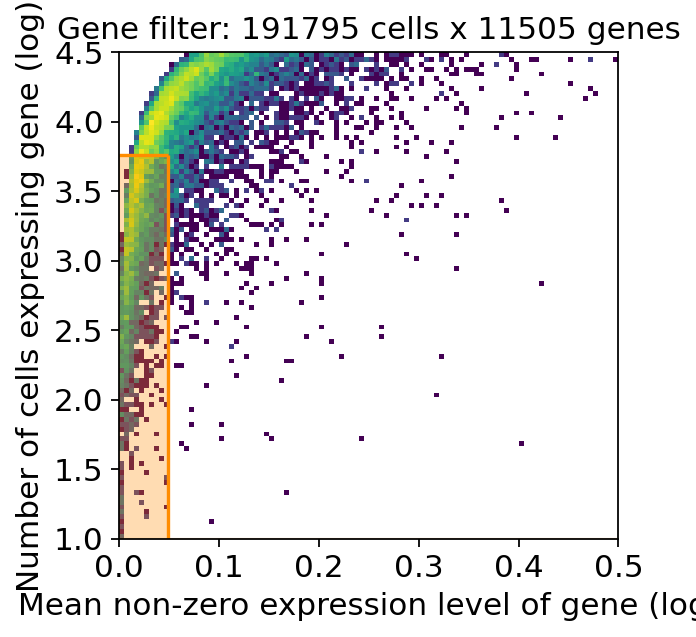

In [6]:
selected = c2l.utils.filtering.filter_genes(adata_sc, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

We can now subset both AnnData objects to the selected genes:

In [7]:
adata_sc = adata_sc[:, selected].copy()
adata_st = adata_st[:, selected].copy()

Cell2location estimates the signatures from the reference data using a Negative binomial regression model which can also account for batch effects and additional categorical covariates. We are passing the `donor_id` and the `assay` as batch and covariate in this tutorial. `setup_anndata` will create the data object that is actually used for training the model.

In [8]:
c2l.models.RegressionModel.setup_anndata(
    adata=adata_sc,
    batch_key='donor_id',
    labels_key='cell_type',
    categorical_covariate_keys=['assay'])

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


We can now train the Regression model and estimate the reference cell type signatures. The default number of epochs is `max_epochs=250`, which might need to be increased to achieve convergence for the dataset at hand. 

Additionally, one might inspect that `batch_size=2500` which is much larger compared to other defaults in scvi-tools and that `train_size=1` which performs training on all cells present in the dataset.

In [9]:
model = c2l.models.RegressionModel(adata_sc)
# default, try on GPU:
use_gpu = True
model.train(max_epochs=250, batch_size=2500, train_size=1, lr=0.002, use_gpu=use_gpu)

/home/icb/anna.schaar/miniconda3/envs/deconvolution_book/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/anna.schaar/miniconda3/envs/deconvolution_ ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/anna.schaar/miniconda3/envs/deconvolution_book/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/anna.schaar/miniconda3/envs/deconvolution_ ...
  rank_zero_warn(
/home/icb/anna.schaar/mi

Epoch 250/250: 100%|███████████████████| 250/250 [49:21<00:00, 11.71s/it, v_num=1, elbo_train=1.1e+9]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|███████████████████| 250/250 [49:21<00:00, 11.85s/it, v_num=1, elbo_train=1.1e+9]


By inspecting the training history, one can determine whether the model needs more training. This plot should have a decreasing trend and should level off, otherwise one needs to increase the `max_epochs` parameter.

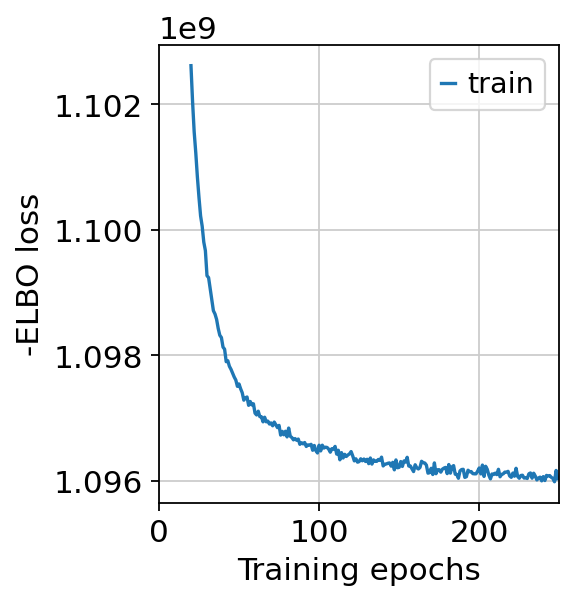

In [10]:
model.plot_history(20)

#### Getting the posterior from C2l

In [11]:
model.export_posterior(
    adata_sc, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': use_gpu}
)

Sampling global variables, sample: 100%|██████████████████████████| 999/999 [00:09<00:00, 102.81it/s]


AnnData object with n_obs × n_vars = 191795 × 11505
    obs: 'sample', 'n_counts', 'n_genes', 'percent_mito', 'doublet_score', 'dissociation_score', 'cell_type_original', 'patient_region_id', 'donor_id', 'patient_group', 'major_labl', 'final_cluster', 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'n_cells', 'nonz_mean'
    uns: 'X_approximate_distribution', 'batch_condition', 'cell_type_colors', 'cell_type_original_colors', 'default_embedding', 'schema_version', 'title', '_scvi_uuid', '_scvi_manager_uuid', 'mod'
    

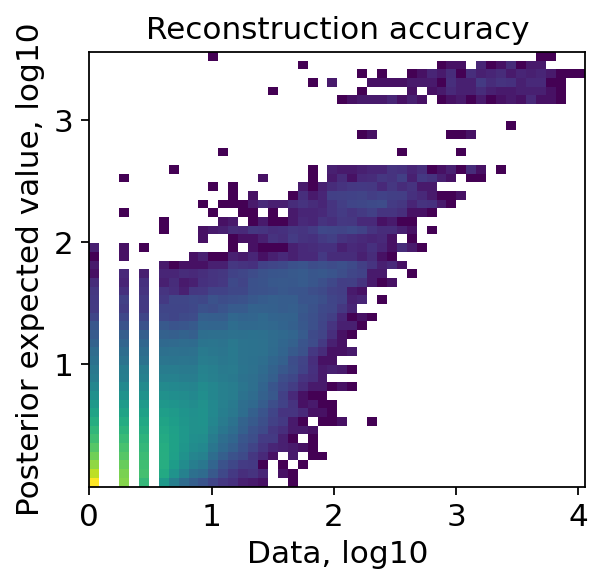

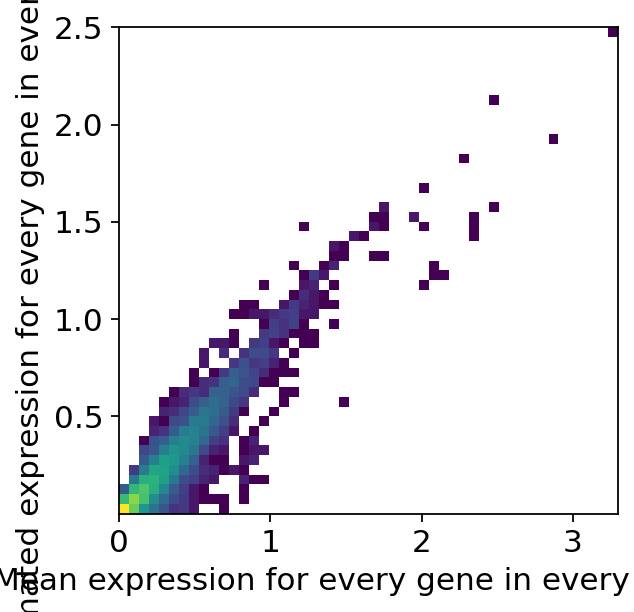

In [12]:
model.plot_QC()

In [13]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_sc.varm.keys():
    inf_aver = adata_sc.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                                              for i in adata_sc.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_sc.var[[f'means_per_cluster_mu_fg_{i}'
                                  for i in adata_sc.uns['mod']['factor_names']]].copy()

We can now extract the inferred cell types signatures. For the subsequent spatial mapping, cell2location needs the estimated gene expression in every cell type. 

If you are running deconvolution on multiple slides for the same reference dataset, it might be reasonable to save the cell types signatures.

In [14]:
inf_aver.columns = adata_sc.uns['mod']['factor_names']
inf_aver.head()

neuronal receptor cell  mast cell  cardiac muscle myoblast  \
feature_id                                                                    
ENSG00000125812                0.005017   0.009073                 0.119288   
ENSG00000022277                0.038683   0.069274                 0.177576   
ENSG00000196776                0.109848   0.378217                 0.404752   
ENSG00000178719                0.021984   0.010202                 0.037403   
ENSG00000168172                0.163327   0.284438                 0.609468   

                 smooth muscle myoblast  pericyte  \
feature_id                                          
ENSG00000125812                0.012022  0.007208   
ENSG00000022277                0.062837  0.047792   
ENSG00000196776                0.113824  0.065910   
ENSG00000178719                0.015190  0.022065   
ENSG00000168172                0.239144  0.212834   

                 lymphoid lineage restricted progenitor cell  \
feature_id                                                     
ENSG00000125812                                     0.002633   
ENSG00000022277                                     0.047987   
ENSG00000196776                                     0.212084   
ENSG00000178719                                     0.001797   
ENSG00000168172                                     0.085207   

                 immature innate lymphoid cell  fibroblast of cardiac tissue  \
feature_id                                                                     
ENSG00000125812                       0.021218                      0.011539   
ENSG00000022277                       0.084077                      0.059137   
ENSG00000196776                       0.155341                      0.153099   
ENSG00000178719                       0.050766                      0.018205   
ENSG00000168172                       0.313318                      0.307642   

                 cardiac endothelial cell  \
feature_id                                  
ENSG00000125812                  0.011135   
ENSG00000022277                  0.063603   
ENSG00000196776                  0.084982   
ENSG00000178719                  0.012841   
ENSG00000168172                  0.187917   

                 adipocyte of epicardial fat of left ventricle  native cell  
feature_id                                                                   
ENSG00000125812                                       0.013139     0.019332  
ENSG00000022277                                       0.223107     0.083839  
ENSG00000196776                                       0.083525     0.194533  
ENSG00000178719                                       0.205971     0.018285  
ENSG00000168172                                       0.751691     0.357581

In [15]:
inf_aver.to_csv('inf_aver.csv')

### Run Cell2Location

Next, we can prepare the data for the actual spatial mapping with `setup_anndata` for the Cell2location model.

In [16]:
c2l.models.Cell2location.setup_anndata(
    adata=adata_st,
    batch_key='donor_id',
    #layer="counts"
)

Cell2location requires two user-provided hyperparameters (`N_cells_per_location` and `detection_alpha`). 

* `N_cells_per_location` describes the expected cell abundance in each location or spot. This can usually be obtained through paired histology images. 

* `detection_alpha` handles the technical varibility in in RNA detection sensitivity within the slide/batch. The technical variability in RNA detection sensitivity can also be extracted based on histological examination. For more information we refer the analyst to the documentation of cell2location. The default value is `detection_alpha=20`.

In [17]:
model = c2l.models.Cell2location(
    adata_st, 
    cell_state_df=inf_aver,
    N_cells_per_location=20,
    detection_alpha=20,
    )

In [18]:
model.train(
    max_epochs=3000,  # default 3000
    batch_size=None,
    train_size=1,
    use_gpu=use_gpu
)

/home/icb/anna.schaar/miniconda3/envs/deconvolution_book/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/anna.schaar/miniconda3/envs/deconvolution_ ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/anna.schaar/miniconda3/envs/deconvolution_book/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/anna.schaar/miniconda3/envs/deconvolution_ ...
  rank_zero_warn(
/home/icb/anna.schaar/mi

Epoch 3000/3000: 100%|██████████████| 3000/3000 [03:57<00:00, 12.68it/s, v_num=1, elbo_train=1.96e+7]

`Trainer.fit` stopped: `max_epochs=3000` reached.


Epoch 3000/3000: 100%|██████████████| 3000/3000 [03:57<00:00, 12.66it/s, v_num=1, elbo_train=1.96e+7]


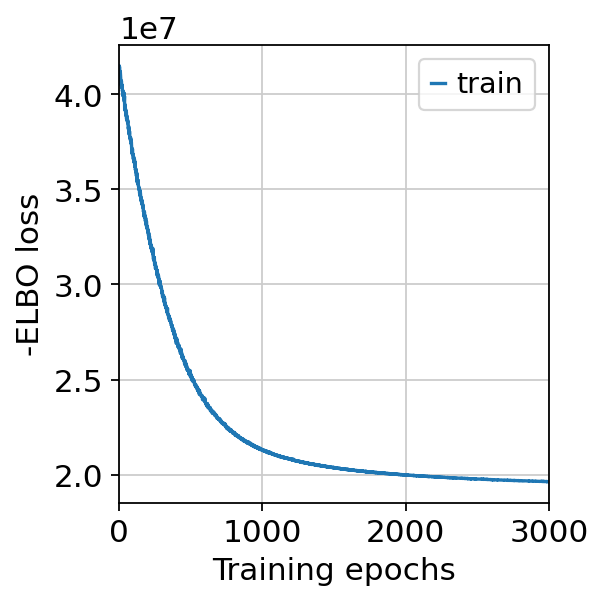

In [19]:
model.plot_history()

In [20]:
adata_st = model.export_posterior(
    adata_st, sample_kwargs={'num_samples': 1000, 'batch_size': model.adata.n_obs, 'use_gpu': use_gpu}
)

Sampling global variables, sample: 100%|███████████████████████████| 999/999 [00:16<00:00, 60.08it/s]


In [21]:
adata_st.obs[adata_st.uns['mod']['factor_names']] = adata_st.obsm['q05_cell_abundance_w_sf']


In [22]:
adata_st.obsm['spatial'] = adata_st.obsm['X_spatial']

### Plotting the results

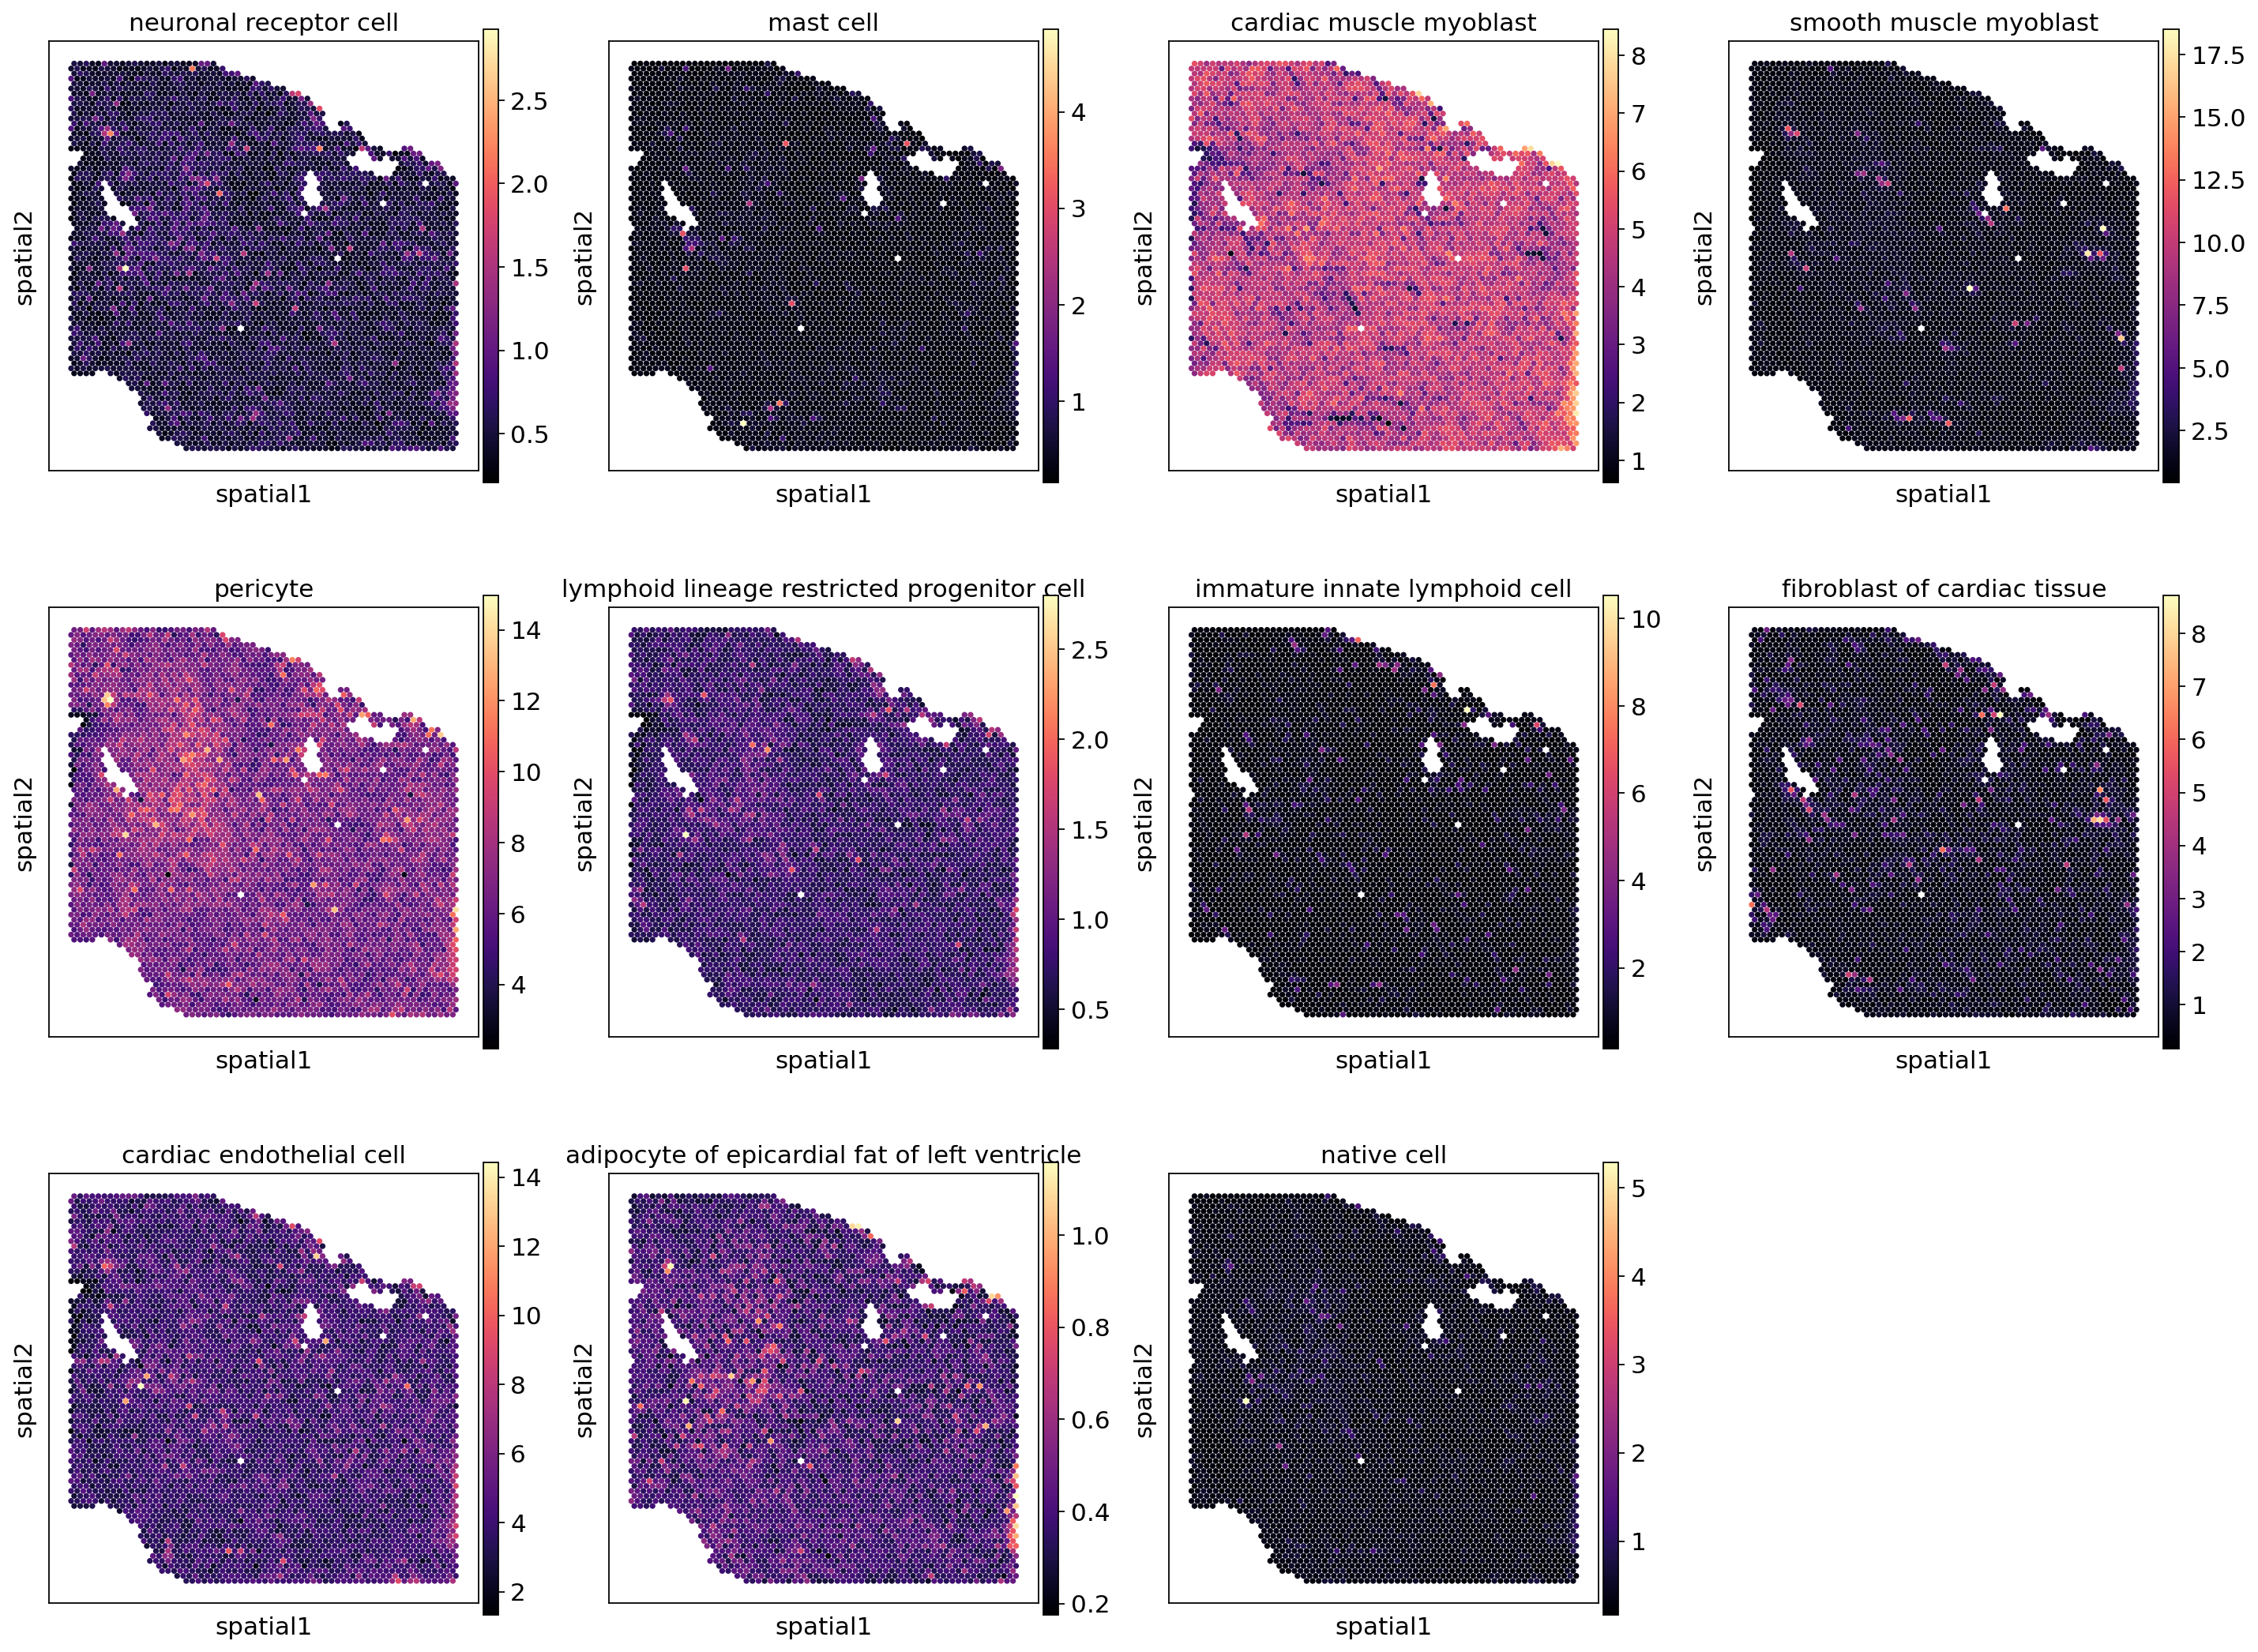

In [24]:
with matplotlib.rc_context({'figure.figsize': [4.5, 5]}):
    sc.pl.spatial(adata_st, cmap='magma',
                  color=adata_st.uns['mod']['factor_names'],
                  ncols=4, size=3.,
                  img_key=None,
                  spot_size=0.005
                 )

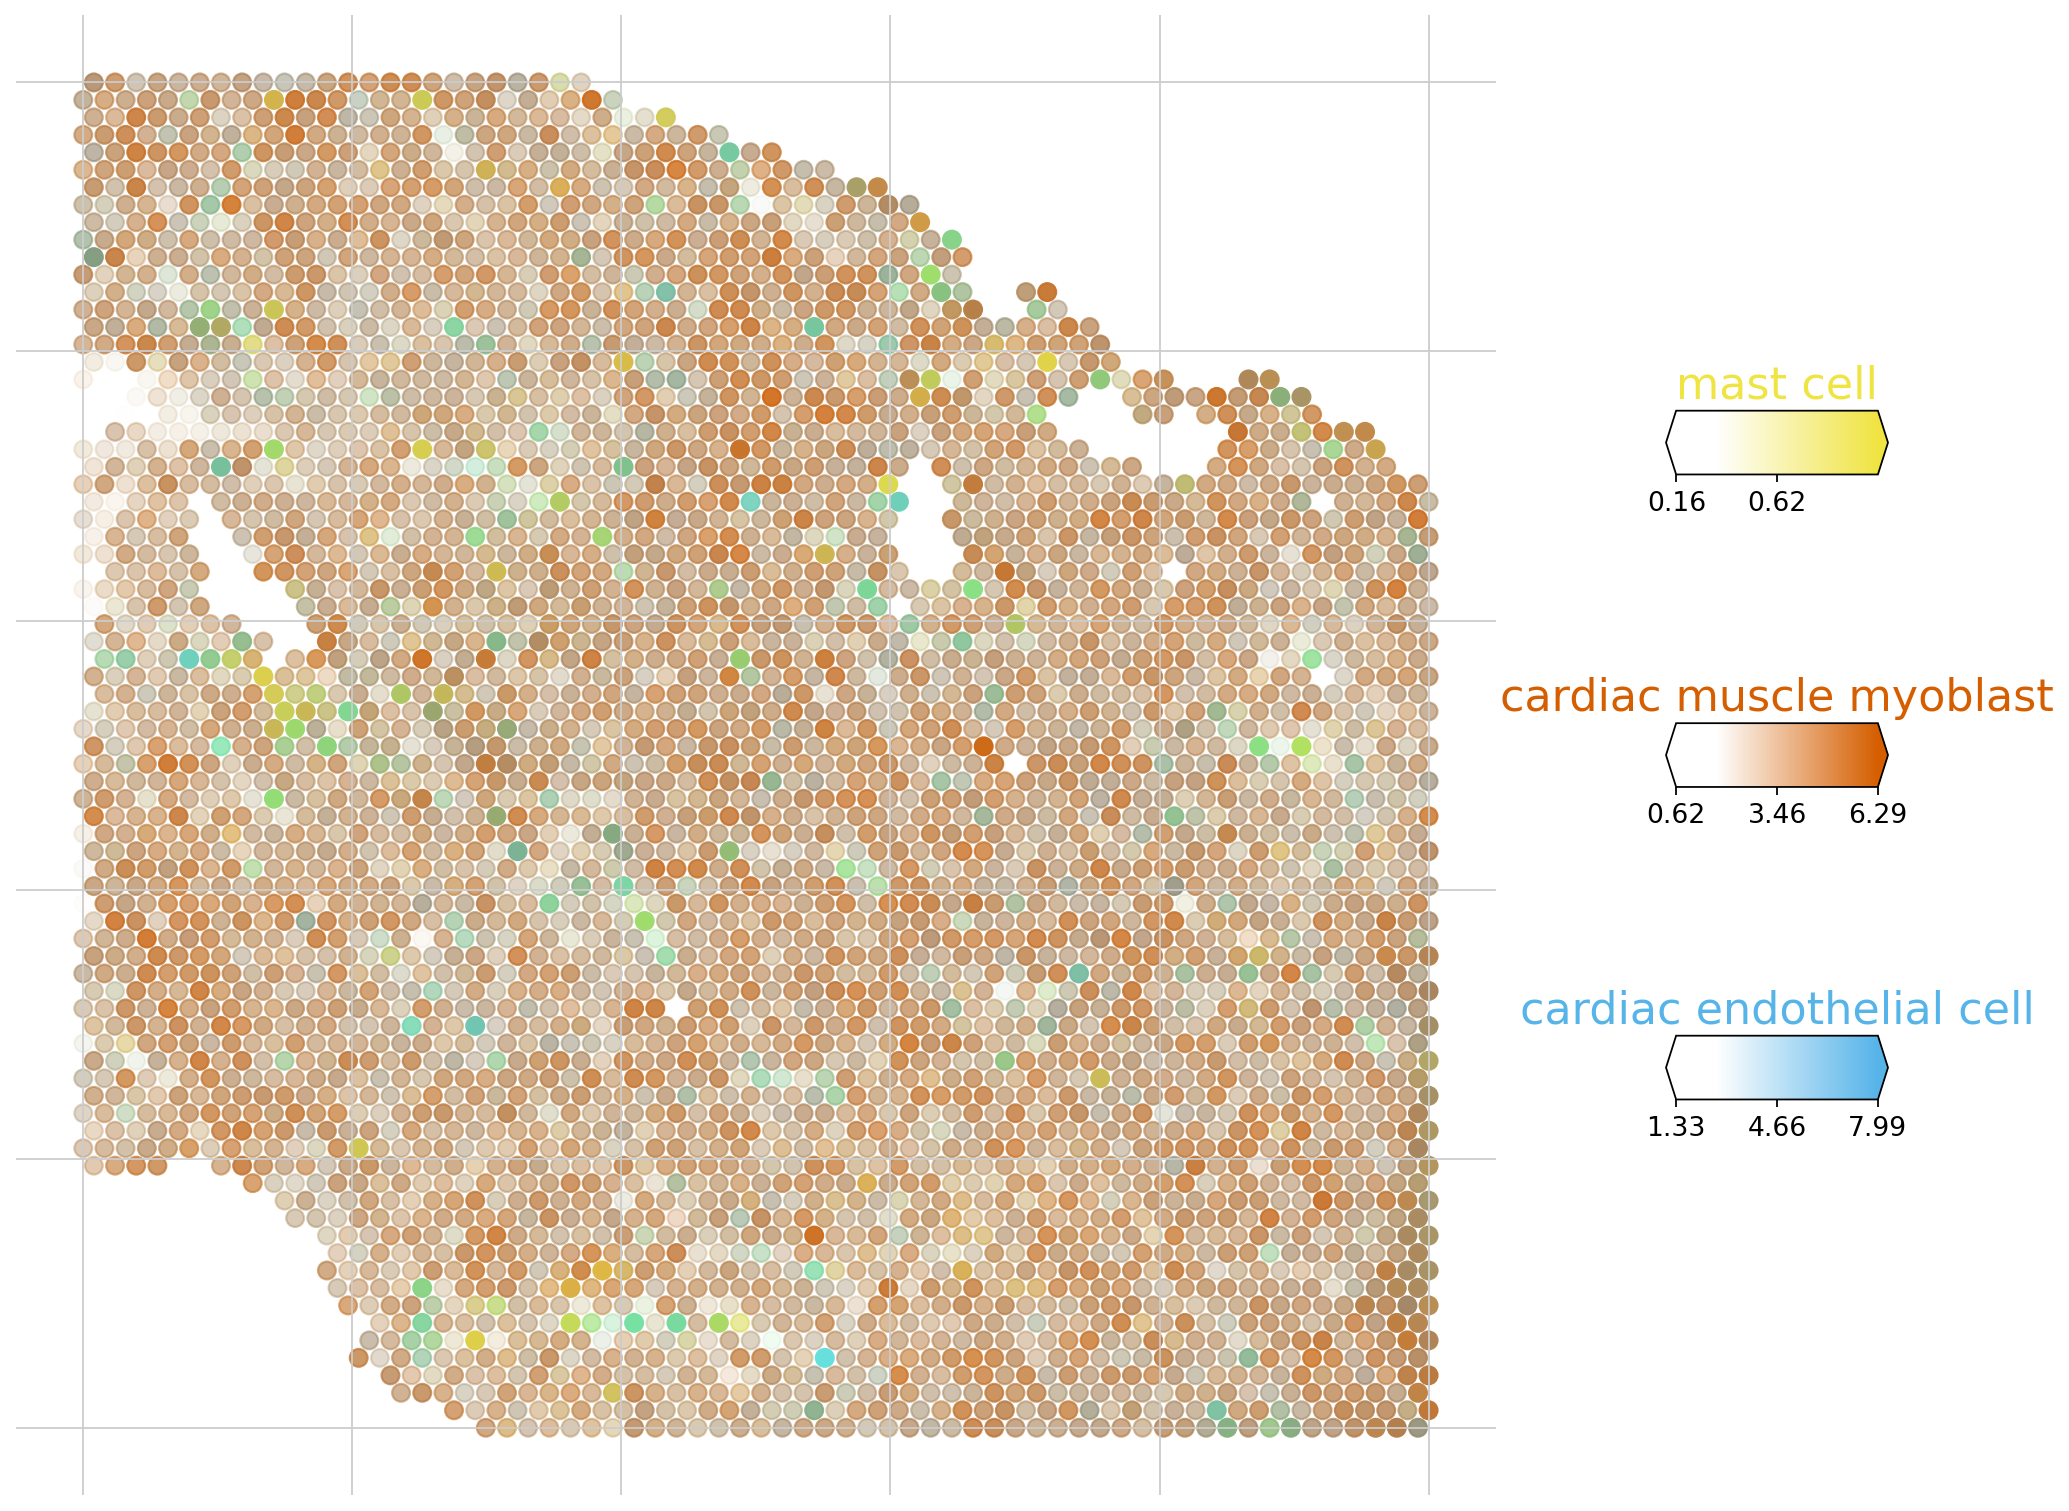

In [25]:
clust_col = ['mast cell','cardiac muscle myoblast','cardiac endothelial cell']
clust_labels = clust_col

with matplotlib.rc_context({'figure.figsize': (15, 15)}):
    fig = c2l.plt.plot_spatial(
        adata=adata_st, color=clust_col, labels=clust_labels,
        max_color_quantile=0.992, circle_diameter=8, show_img=False, 
        colorbar_position="right", colorbar_shape={"horizontal_gaps":0.2}
    )

# Further Models in Reference Based Deconvolution

DestVI cite{`lopez_destvi_2022`} incorporates complex nonlinear relationships into the latent variable setup through the use of neural networks. It is the first model that allows for variation of cell type expression prototypes in the data set through a latent variable. These concepts combine to parameterize the mean of a standard negative binomial distribution with gene dependent success probability $p_g$ as in Stereoscope.

RCTD cite{`cable_robust_2022`} is a reference based deconvolution model which uses the Poisson distribution instead of the more common negative binomial. For its reference cell type prototypes, it simply uses mean expressions for each cell type. This straightforward approach aims for maximum robustness and has shown particular promise in the deconvolution of cell doublets.

SPOTlight cite{`elosua-bayes_spotlight_2021`} uses non-negative matrix factorisation to first decompose the cells by genes matrix from a reference into two parts. First, a cells by topics matrix $H$ and a topics by genes matrix $W$. The matrix $W$ is then transferred to ST where a spots by topics matrix $H'$ is inferred. Topics are not exactly cell types and much care has to be put to ensure that correct latent features are modeled. 

# Key takeaways
# References

```{bibliography}
:filter: docname in docnames
:labelprefix: spatial
```

# Contributors
## Authors
* Leon Hetzel
* Anna Schaar

## Reviewers
